In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
from sklearn.isotonic import IsotonicRegression

In [2]:
ls

calibrated_regression_s-Copy1.ipynb  out.train_ensemble
ensemble_results.ipynb               s_calibration_model.joblib
ensemble_results_NGB.ipynb           s_calibration_model_medians.joblib
eval_swag_picker.sh*                 seed1_128_0.003_5e-3_0.001_56_25_20/
figures/                             seed2_128_0.003_5e-3_0.001_56_25_20/
figures_median/                      seed3_128_0.003_5e-3_0.001_56_25_20/
figures_NGB/                         selected_models/
figures_NGB_medians/                 train_s_swag_picker.sh*
out.eval_ensemble_loop


In [3]:
def load_model_results(file_name):
    file = np.load(file_name)
    predictions = file["predictions"]
    targets = file["targets"][:, 0]
    pred_mean = file["prediction_mean"]
    pred_std = file["prediction_std"]
    resids = targets - pred_mean

    return predictions, pred_mean, pred_std, targets, resids

def load_ensemble_predictions(dtype, data_path):
    model1_file = f"seed1_128_0.003_5e-3_0.001_56_25_20/eval/swag_{dtype}_uncertainty_50.npz"
    model2_file = f"seed2_128_0.003_5e-3_0.001_56_25_20/eval/swag_{dtype}_uncertainty_50.npz"
    model3_file = f"seed3_128_0.003_5e-3_0.001_56_25_20/eval/swag_{dtype}_uncertainty_50.npz"

    model1_preds, model1_pred_mean, model1_pred_std, model1_targets, model1_resids = load_model_results(model1_file)
    model2_preds, model2_pred_mean, model2_pred_std, model2_targets, model2_resids = load_model_results(model2_file)
    model3_preds, model3_pred_mean, model3_pred_std, model3_targets, model3_resids = load_model_results(model3_file)

    # Join all predictions
    ensemble_predictions = np.concatenate([model1_preds, model2_preds, model3_preds], axis=1)
    # Get predicted pick and std
    ##ensemble_means = np.mean(ensemble_predictions, axis=1)
    ensemble_medians = np.median(ensemble_predictions, axis=1)
    ensemble_stds = np.std(ensemble_predictions, axis=1)
    # Ensure targets are the same for all three models
    assert np.array_equal(model1_targets, model2_targets)
    assert np.array_equal(model1_targets, model3_targets)
    # Calculate residual stats (actual-predicted)
    ##pick_residuals = model1_targets - ensemble_means
    pick_residuals = model1_targets - ensemble_medians
    residual_mean = np.mean(pick_residuals)
    residual_std = np.std(pick_residuals)

    # Combine into a dataframe
    ##df_data = {"y_pred":ensemble_means, "std":ensemble_stds, "y_act":model1_targets, "residual":pick_residuals}
    df_data = {"y_pred":ensemble_medians, "std":ensemble_stds, "y_act":model1_targets, "residual":pick_residuals}

    df = pd.DataFrame(data=df_data)
    df.head()

    # read in meta_df
    if dtype=="test":
        dtype="test_fewerhist"
    meta_df = pd.read_csv(f"{data_path}/uuss_{dtype}.csv")

    return df, meta_df

In [4]:
val_df, val_meta_df = load_ensemble_predictions("validation", "../uuss_data/s_resampled")
test_df, test_meta_df = load_ensemble_predictions("test_fewerhist", "../uuss_data/s_resampled")

In [5]:
print("Validation df lengths:", len(val_df), len(val_meta_df))
print("Test df lengths:", len(test_df), len(test_meta_df))
print("Shared evids between datasets?:", np.any(np.isin(test_meta_df.evid.unique(), val_meta_df.evid.unique())))

Validation df lengths: 8211 8211
Test df lengths: 8326 8326
Shared evids between datasets?: False


# Accurate Uncertainties for Deep Learning Using Calibrated Regression
Recalibration dataset $D = \{ (F_t(y_t) , \hat{P}(F_t(y_t))) \}_{t=1}^T$
1. Compute $F_t$ = CDF[$N(\mu_t, \sigma^2_t)]$ for t $\in$ [1, T]
2. Evalute $F_t(y_t)$ for t $\in$ [1, T]
3. compute $\hat{P}(p)=\frac{| \{y_t | F_t(y_t) \leq p, t=1...,T \}|}{T}$, where $p=F_t(y_t)$ for t $\in$ [1, T]

Fit Isotonic Regression model R to D

- Fitting regression model to D' = $\{( \hat{P}(F_t(y_t)), F_t(y_t)) \}_{t=1}^T$ seems easier for adjusting the "standard deviation" to be calibrated.
- When using D, will need to compute the CDF of the Gaussian with predicted $\mu$ and $\sigma$, transform with R, and then invert for $x_{lb}$ and $x_{ub}$. Since the CDF has been transformed, norm.ppf can no longer be used to invert. 
- When using D', can compute the ppf of the gaussian with predicted $\mu$ and $\sigma$ and evaluate it at R(lb) and R(ub). 
- I show below that $x_{lb}$ and $x_{ub}$ computed using the D' method intersect with the transformed CDF computed using D at 0.16 and 0.84. 

## Fit Predicted vs Empirical Curve $D = \{ (F_t(y_t) , \hat{P}(F_t(y_t))) \}_{t=1}^T$ with Isotonic Regression

In [6]:
# Do steps 1 & 2
def eval_cdf(df):
    df["cdf"] = df.apply(lambda x: norm.cdf(x["y_act"], x["y_pred"], x["std"]), axis=1)
    print(df.head())
eval_cdf(val_df)

     y_pred       std  y_act  residual       cdf
0  0.460639  0.049290   0.51  0.049361  0.841695
1 -0.154265  0.038570  -0.25 -0.095735  0.006531
2  0.547134  0.075787   0.52 -0.027134  0.360162
3  0.362080  0.098211   0.31 -0.052080  0.297954
4  0.370668  0.069684   0.39  0.019332  0.609271


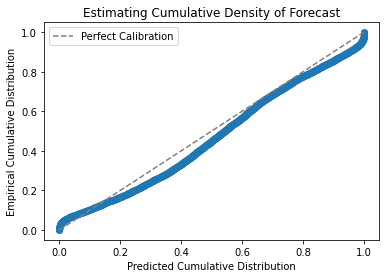

In [7]:
# Do step 3
def plot_empirical_cdf(df, swap_xy=False):
    fig = plt.figure()
    plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), color="gray", linestyle="--", label="Perfect Calibration")
    if not swap_xy:
        plt.scatter(df.cdf.values, df.p_hat.values, alpha=0.1)
        plt.ylabel("Empirical Cumulative Distribution")
        plt.xlabel("Predicted Cumulative Distribution")
    else:
        plt.scatter(df.p_hat.values, df.cdf.values, alpha=0.1)
        plt.xlabel("Empirical Cumulative Distribution")
        plt.ylabel("Predicted Cumulative Distribution")
    plt.title("Estimating Cumulative Density of Forecast")
    plt.legend();
    plt.show()
    
def compute_empirical_cdf(df, swap_xy=False):
    p_hat = []
    T = len(df)
    for index, row in df.iterrows():
        p = row["cdf"]
        p_hat.append((df["cdf"] <= p).sum()/T)
    df["p_hat"] = p_hat

    plot_empirical_cdf(df, swap_xy)
compute_empirical_cdf(val_df)

In [8]:
def check_nondecreasing(df):
    assert ~np.any(np.diff(df.sort_values("cdf")["p_hat"].values) < 0), "CDF vs P_Hat is not non-decreasing"
    assert ~np.any(np.diff(df.sort_values("p_hat")["cdf"].values) < 0), "P_Hat vs CDF is not non-decreasing"
    
check_nondecreasing(val_df)

In [9]:
def plot_calibration_curve(df, regressor, title, swap_xy=False):
    p_hat_cal = []
    p_hat_uncal = []
    T = len(df)
    for p in np.arange(0, 1.05, 0.05):
        if swap_xy:
            p_hat_cal.append((df.cdf <= regressor.predict([p])[0]).sum()/T)
        else:
            p_hat_cal.append((regressor.predict(df.cdf) <= p).sum()/T)
        
        p_hat_uncal.append((df["cdf"] <= p).sum()/T)

    plt.plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color="gray", linestyle="--")
    plt.plot(np.arange(0, 1.05, 0.05), p_hat_cal, marker="o", label="calibrated")
    plt.plot(np.arange(0, 1.05, 0.05), p_hat_uncal, marker="o", label="uncalibrated")
    plt.legend()
    plt.title(title)

## Fit Empirical vs Predicted Curve $D=\{( \hat{P}(F_t(y_t)), F_t(y_t)) \}_{t=1}^T$ with Isotonic Regression

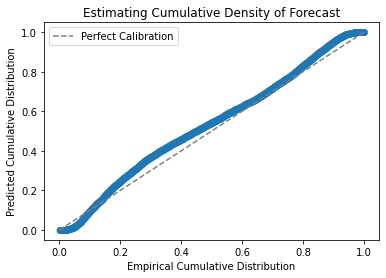

In [10]:
#WITH MEDIAN - ensemble
plot_empirical_cdf(val_df, swap_xy=True)

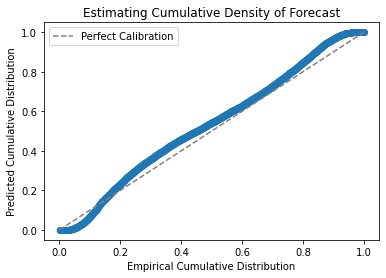

In [10]:
#WITH MEDIAN - not ensemble
plot_empirical_cdf(val_df, swap_xy=True)

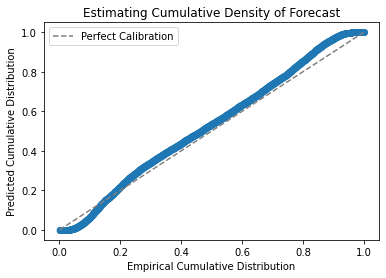

In [10]:
# WITH MEAN
plot_empirical_cdf(val_df, swap_xy=True)

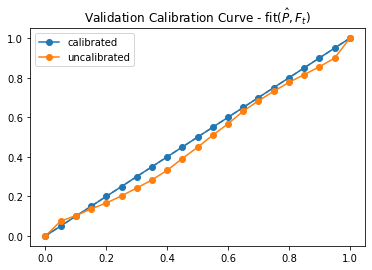

In [11]:
# Fit isotonic regression model to Empirical vs Predicted curve. 
iso_reg_inv = IsotonicRegression().fit(val_df.p_hat.values, val_df.cdf.values)
plot_calibration_curve(val_df, iso_reg_inv, r"Validation Calibration Curve - fit$(\hat{P}, F_t)$", swap_xy=True)

     y_pred       std  y_act  residual       cdf
0  0.520706  0.044661   0.51 -0.010706  0.405274
1 -0.275394  0.055508  -0.25  0.025394  0.676337
2  0.531448  0.084093   0.52 -0.011448  0.445856
3  0.305078  0.039237   0.31  0.004922  0.549911
4  0.499487  0.052003   0.39 -0.109487  0.017628


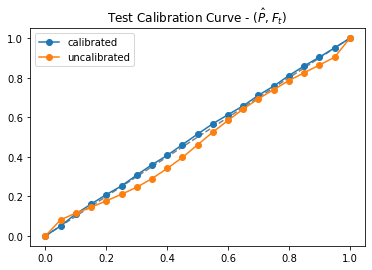

In [12]:
eval_cdf(test_df)
plot_calibration_curve(test_df, iso_reg_inv, r"Test Calibration Curve - $(\hat{P}, F_t)$", swap_xy=True)

# Go with Isotonic Regression of $D = \{(\hat{P}(F_t(y_t)), F_t(y_t))\}_{t=1}^T$...
(Empirical vs Predicted) because it is easier to adjust the X bounds to truly contain 68% of the data. The other ways is better for identifying what percent of data are truly within the original 68% bounds (e.g. 68% -> 39%). 

In [13]:
lb = 0.05
ub = 0.95

# Transform the lower and upper bounds to be calibrated
lb_transform = iso_reg_inv.transform([lb])[0]
ub_transform = iso_reg_inv.transform([ub])[0]

# Compute the lower and upper bounds for each prediction given the mean and std
test_df["lb_y"] = test_df.apply(lambda x: norm.ppf(lb_transform, x["y_pred"], x["std"]), axis=1)
test_df["ub_y"] = test_df.apply(lambda x: norm.ppf(ub_transform, x["y_pred"], x["std"]), axis=1)

test_df.head()

,y_pred,std,y_act,residual,cdf,lb_y,ub_y
0,0.520706,0.044661,0.51,-0.010706,0.405274,0.424979,0.629124
1,-0.275394,0.055508,-0.25,0.025394,0.676337,-0.394369,-0.140646
2,0.531448,0.084093,0.52,-0.011448,0.445856,0.351203,0.735588
3,0.305078,0.039237,0.31,0.004922,0.549911,0.220978,0.400328
4,0.499487,0.052003,0.39,-0.109487,0.017628,0.388025,0.625727


In [14]:
# Compute the lower and upper bounds for each prediction given the mean and std
val_df["lb_y"] = val_df.apply(lambda x: norm.ppf(lb_transform, x["y_pred"], x["std"]), axis=1)
val_df["ub_y"] = val_df.apply(lambda x: norm.ppf(ub_transform, x["y_pred"], x["std"]), axis=1)

test_df.head()

,y_pred,std,y_act,residual,cdf,lb_y,ub_y
0,0.520706,0.044661,0.51,-0.010706,0.405274,0.424979,0.629124
1,-0.275394,0.055508,-0.25,0.025394,0.676337,-0.394369,-0.140646
2,0.531448,0.084093,0.52,-0.011448,0.445856,0.351203,0.735588
3,0.305078,0.039237,0.31,0.004922,0.549911,0.220978,0.400328
4,0.499487,0.052003,0.39,-0.109487,0.017628,0.388025,0.625727


In [15]:
# Fraction of true picks that are within the calibrated lower and upper bounds 
((test_df["y_act"] > test_df["lb_y"]) & (test_df["y_act"] < test_df["ub_y"])).sum()/len(test_df)

0.9005524861878453

In [16]:
((val_df["y_act"] > val_df["lb_y"]) & (val_df["y_act"] < val_df["ub_y"])).sum()/len(val_df)

0.9000121787845573

In [17]:
from joblib import dump
dump(iso_reg_inv, 's_calibration_model_medians_ensemble.joblib') 

['s_calibration_model_medians_ensemble.joblib']

In [16]:
ls

calibrated_regression_s-Copy1.ipynb  s_calibration_model.joblib
ensemble_results.ipynb               s_calibration_model_medians.joblib
ensemble_results_NGB.ipynb           seed1_128_0.003_5e-3_0.001_56_25_20/
eval_swag_picker.sh*                 seed2_128_0.003_5e-3_0.001_56_25_20/
figures/                             seed3_128_0.003_5e-3_0.001_56_25_20/
figures_NGB/                         selected_models/
out.eval_ensemble_loop               train_s_swag_picker.sh*
out.train_ensemble
